In [1]:
import numpy as np
import scipy.io as sio
import os
import cv2
from FeatureExtractor import FeatureExtractor
import h5py
import pickle
import json
from scipy.spatial.distance import cdist
from copy import *
from myresize import myresize
import math

# target vc
vc = 1
thres4 = 0.42
Astride = 16
Apad = 42
Arf = 100
scale_size=224

file_path = '/export/home/qliu24/qing_voting_data/intermediate/feat_car/'
filename = file_path + 'car_mergelist_rand_train_car_pool4_vMFMM.pickle'

with open(filename, 'rb') as fh:
    layer_feature, _ = pickle.load(fh)
    
dict_file='/export/home/qliu24/qing_voting_139/qing_voting_py/data/dictionary_imagenet_car_vgg16_pool4_K176_norm_nowarp_prune_512.pickle'
with open(dict_file, 'rb') as fh:
    _, centers = pickle.load(fh)

centers = centers/np.sqrt(np.sum(centers**2, axis=1)).reshape(-1,1)


dir_img = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Images/car_imagenet/'
dir_anno = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Annotations/car_imagenet/'
file_list = '/export/home/qliu24/qing_voting_139/qing_voting_py/intermediate/ground_truth_data/car_mergelist_rand_train.txt'

with open(file_list, 'r') as fh:
    content = fh.readlines()

img_list = [x.strip().split() for x in content]
img_num = len(img_list)
assert(img_num == len(layer_feature))
print('total number of images for {1}: {0}'.format(img_num, 'car'))

vc_patch_ls = []
for nn in range(img_num):
    file_img = os.path.join(dir_img, '{0}.JPEG'.format(img_list[nn][0]))
    assert(os.path.isfile(file_img))
    img = cv2.imread(file_img)
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.show()

    height, width = img.shape[0:2]

    file_anno = os.path.join(dir_anno, '{0}.mat'.format(img_list[nn][0]))
    assert(os.path.isfile(file_anno))
    mat_contents = sio.loadmat(file_anno)
    record = mat_contents['record']
    objects = record['objects']
    bbox = objects[0,0]['bbox'][0,int(img_list[nn][1])-1][0]
    bbox = [max(math.ceil(bbox[0]), 1), max(math.ceil(bbox[1]), 1), \
            min(math.floor(bbox[2]), width), min(math.floor(bbox[3]), height)]
    patch = img[bbox[1]-1: bbox[3], bbox[0]-1: bbox[2], :]
    # patch = cv2.resize(patch, (scale_size, scale_size))
    patch = myresize(patch, scale_size, 'short')
    pheight, pwidth = patch.shape[0:2]
    
    
    iheight,iwidth = layer_feature[nn].shape[0:2]
    lff = layer_feature[nn].reshape(-1, 512)
    lff_norm = lff/np.sqrt(np.sum(lff**2, 1)).reshape(-1,1)
    lfd = cdist(lff_norm, centers, 'cosine').reshape(iheight,iwidth,-1)
    rff, cff = np.where(lfd[:,:,vc] < thres4)
    irff = Astride * rff - Apad
    icff = Astride * cff - Apad
    
    for rii, cii in zip(irff, icff):
        if rii >=0 and rii <= pheight-Arf and cii >=0 and cii <= pwidth-Arf:
            fpatch = np.expand_dims(patch[rii:rii+Arf, cii:cii+Arf, :], axis=0)
            vc_patch_ls.append(fpatch)

vc_patch_ls = np.concatenate(vc_patch_ls, axis=0)
print(vc_patch_ls.shape)
if vc_patch_ls.shape[0]>1999:
    vc_patch_ls = vc_patch_ls[np.random.permutation(vc_patch_ls.shape[0])[0:1999],:,:,:]
    
print(vc_patch_ls.shape)

total number of images for car: 1000
(6841, 100, 100, 3)
(1999, 100, 100, 3)


(2000, 3, 100, 100)
-5.0 260.000007629


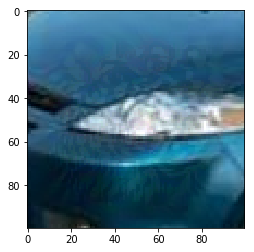

In [55]:
# visualize Feng's samples
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

file1 = '/export/home/qliu24/VC_adv_data/feng/adversial_samples_vc4_vMFMM_2000.mat'
file2 = '/export/home/qliu24/VC_adv_data/feng/original_samples_vc4_vMFMM_2000.mat'
ff = h5py.File(file1)
sample = np.array(ff[ff['adversial_samples'][0][0]].value).astype(float)
print(sample.shape)

vgg_mean = np.float32([103.939, 116.779, 123.68])
# sample = np.array(matcontent['adversial_samples'][10][0][:,:,:,49]).astype(float)
sample = np.transpose(sample, [0,2,3,1]) + vgg_mean
sample = sample[:,:,:,[2,1,0]]
print(np.min(sample), np.max(sample))
sample = np.maximum(sample, 0)
sample = np.minimum(sample, 255)
sample = sample.astype('uint8')
plt.imshow(sample[49])
plt.show()

[ 295.87205082  140.77676951  469.19328494  275.07803993]
[296, 141, 469, 275]


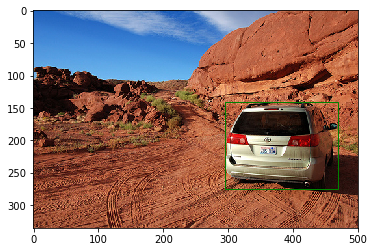

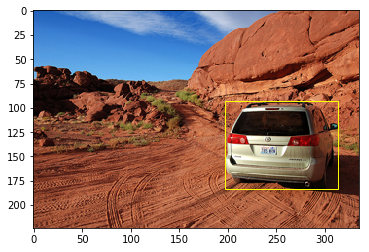

In [10]:
# visualize Cihang's samples
import numpy as np
import scipy.io as sio
import os
import cv2
from FeatureExtractor import FeatureExtractor
import h5py
import pickle
import json
from scipy.spatial.distance import cdist
from copy import *
from myresize import myresize
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

file = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/adv_mat_file/n02814533_10404.mat'
matcontent = sio.loadmat(file)


anno_file = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Annotations/car_imagenet/n02814533_10404.mat'
anno = sio.loadmat(anno_file)
record = anno['record']

img_file = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Images/car_imagenet/n02814533_10404.JPEG'
img = cv2.imread(img_file)
fig,ax = plt.subplots()
ax.imshow(img[:,:,[2,1,0]])

width,height = record['imgsize'][0][0][0][0:2]
objects = record['objects']
bbox = objects[0,0]['bbox'][0,0][0]
print(bbox)
bbox = [max(math.ceil(bbox[0]), 1), max(math.ceil(bbox[1]), 1), \
        min(math.floor(bbox[2]), width), min(math.floor(bbox[3]), height)]
print(bbox)


rect = patches.Rectangle((bbox[0]-1,bbox[1]-1),bbox[2]-bbox[0]+1,bbox[3]-bbox[1]+1,\
                             linewidth=1,edgecolor='green',facecolor='none')
ax.add_patch(rect)
plt.show()

ratio = 224/height
bbox2 = np.array(bbox, dtype='int')*ratio
fig,ax = plt.subplots()
ax.imshow(matcontent['im_ori'])
rect = patches.Rectangle((bbox2[0]-1,bbox2[1]-1),bbox2[2]-bbox2[0]+1,bbox2[3]-bbox2[1]+1,\
                             linewidth=1,edgecolor='yellow',facecolor='none')
ax.add_patch(rect)
plt.show()

In [1]:
import network as vgg
import tensorflow as tf
import numpy as np
import tensorflow.contrib.slim as slim
from datetime import datetime
import os

def get_init_restorer(bn=False, vc=False):
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes = ['vgg_16/fc8']

    if not bn:
        checkpoint_exclude_scopes.append('BatchNorm')  # restore bn params
    if not vc:
        checkpoint_exclude_scopes.append('vc_centers')  # restore bn params

    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in tf.global_variables():
        excluded = False
        for exclusion in exclusions:
            if exclusion in var.op.name:
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)
    
    return tf.train.Saver(variables_to_restore)

with tf.device('/cpu:0'):
    x_input = tf.placeholder(tf.float32, [20, 100, 100, 3])
    
checkpoints_dir = '/export/home/qliu24/qing_voting_139/qing_voting_py/cache/checkpoints_vgg/'
vgg_var_scope = 'vgg_16'

with tf.variable_scope(vgg_var_scope, reuse=False):
    with slim.arg_scope(vgg.vgg_arg_scope(padding='VALID', bn=False, is_training=False)):
        _, _ = vgg.vgg_16(x_input, is_training=False)
        
restorer = get_init_restorer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
print(str(datetime.now()) + ': Start Init')
restorer.restore(sess, os.path.join(checkpoints_dir, 'vgg_16.ckpt'))
print(str(datetime.now()) + ': Finish Init')

2017-07-21 17:06:17.044858: Start Init
INFO:tensorflow:Restoring parameters from /export/home/qliu24/qing_voting_139/qing_voting_py/cache/checkpoints_vgg/vgg_16.ckpt
2017-07-21 17:06:17.456562: Finish Init


In [ ]:
features = tf.get_default_graph().get_tensor_by_name(vgg_var_scope + '/pool4/MaxPool:0')
loss = tf.norm(features)